In [4]:
import json
import re
import torch
from tqdm import tqdm

# Load the JSON file
with open('/kaggle/input/anlp-project-data/train.json', 'r') as file:
    data = json.load(file)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Extract documents and labels
documents = data['documents']
labels = data['labels']

# Define a function to clean text by removing special characters
def clean_text(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# Parse and format the data
training_data = []
for doc in tqdm(documents):
    doc_text = clean_text(doc['text'])
    annotations = doc['annotation_sets'][0]['annotations']
    
    for hypothesis_name, annotation in annotations.items():
        choice = annotation['choice']
        hypothesis_text = clean_text(labels[hypothesis_name]['hypothesis'])
        combined_text = f"{doc_text} [SEP] {hypothesis_text}"
        
        # Append each document-hypothesis pair along with the label to training data
        training_data.append((combined_text, choice))


100%|██████████| 423/423 [00:00<00:00, 4255.84it/s]


In [5]:
print(len(training_data))

7191


In [6]:
import numpy as np

# Load GloVe embeddings
def load_glove_embeddings(glove_file='/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt', embedding_dim=100):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

# Load the embeddings
embedding_dim = 100
embeddings_index = load_glove_embeddings()

In [7]:
# Convert text to embedding sequence using GloVe
def text_to_embedding(text, embeddings_index, embedding_dim=100):
    words = text.split()
    embedding_sequence = [embeddings_index.get(word, np.zeros(embedding_dim)) for word in words]
    
    embedding_sequence = np.array(embedding_sequence)
    
    return torch.tensor(embedding_sequence, dtype=torch.float32).to(device)

In [8]:
label_mapping = {'Entailment': 0, 'Contradiction': 1, 'NotMentioned': 2}
encoded_labels = [label_mapping[label] for _, label in training_data]


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim


class ContractNLIModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ContractNLIModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiply by 2 for bidirectionality
    
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        
        # Concatenate the final hidden states from both directions
        hn = torch.cat((hn[-2], hn[-1]), dim=1)
        
        out = self.fc(hn)
        return out


# Initialize the model, criterion, and optimizer
input_dim = embedding_dim
hidden_dim = 128
output_dim = 3  # 3 classes

model = ContractNLIModel(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Load and clean validation data
with open('/kaggle/input/anlp-project-data/dev.json', 'r') as file:
    validation_data = json.load(file)

val_documents = validation_data['documents']
val_labels = validation_data['labels']

# Process validation data in the same way as training data
validation_set = []
for doc in tqdm(val_documents):
    doc_text = clean_text(doc['text'])
    annotations = doc['annotation_sets'][0]['annotations']
    
    for hypothesis_name, annotation in annotations.items():
        choice = annotation['choice']
        hypothesis_text = clean_text(val_labels[hypothesis_name]['hypothesis'])
        combined_text = f"{doc_text} [SEP] {hypothesis_text}"
        validation_set.append((combined_text, choice))

100%|██████████| 61/61 [00:00<00:00, 1627.78it/s]


In [10]:
# Training loop with validation loss
epochs = 5
for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for text, label in tqdm(training_data, desc="Training"):
        input_tensor = text_to_embedding(text, embeddings_index, embedding_dim).unsqueeze(0)  # Add batch dimension
        
        target = torch.tensor([label_mapping[label]], dtype=torch.long).to(device)
        
        optimizer.zero_grad()
        
        output = model(input_tensor)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(training_data)
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}')

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for text, label in tqdm(validation_set, desc="Validation"):
            input_tensor = text_to_embedding(text, embeddings_index, embedding_dim).unsqueeze(0)
            
            target = torch.tensor([label_mapping[label]], dtype=torch.long).to(device)
            
            output = model(input_tensor)
            
            loss = criterion(output, target)
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(validation_set)
    print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}')

Training: 100%|██████████| 7191/7191 [02:40<00:00, 44.87it/s] 


Epoch [1/5], Training Loss: 0.7463


Validation: 100%|██████████| 1037/1037 [00:13<00:00, 75.31it/s]


Epoch [1/5], Validation Loss: 0.8346


Training: 100%|██████████| 7191/7191 [02:39<00:00, 45.21it/s] 


Epoch [2/5], Training Loss: 0.6933


Validation: 100%|██████████| 1037/1037 [00:13<00:00, 74.13it/s]


Epoch [2/5], Validation Loss: 0.8668


Training: 100%|██████████| 7191/7191 [02:39<00:00, 45.22it/s] 


Epoch [3/5], Training Loss: 0.6855


Validation: 100%|██████████| 1037/1037 [00:13<00:00, 75.30it/s]


Epoch [3/5], Validation Loss: 0.8348


Training: 100%|██████████| 7191/7191 [02:39<00:00, 45.19it/s] 


Epoch [4/5], Training Loss: 0.6806


Validation: 100%|██████████| 1037/1037 [00:13<00:00, 75.36it/s]


Epoch [4/5], Validation Loss: 0.8292


Training: 100%|██████████| 7191/7191 [02:39<00:00, 45.22it/s] 


Epoch [5/5], Training Loss: 0.6706


Validation: 100%|██████████| 1037/1037 [00:13<00:00, 74.54it/s]

Epoch [5/5], Validation Loss: 0.8378


In [16]:
# Calculate accuracy on the test set

with open('/kaggle/input/anlp-project-data/test.json', 'r') as file:
    test_data = json.load(file)

test_documents = test_data['documents']
test_labels = test_data['labels']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Process test data in the same way as training data
test_set = []
for doc in tqdm(test_documents):
    doc_text = clean_text(doc['text'])
    annotations = doc['annotation_sets'][0]['annotations']
    
    for hypothesis_name, annotation in annotations.items():
        choice = annotation['choice']
        hypothesis_text = clean_text(test_labels[hypothesis_name]['hypothesis'])
        combined_text = f"{doc_text} [SEP] {hypothesis_text}"
        test_set.append((combined_text, choice))

model.eval()
correct_predictions = 0

with torch.no_grad():
    for text, label in tqdm(test_set, desc="Testing"):
        # Convert text to embeddings and move to device
        input_tensor = text_to_embedding(text, embeddings_index, embedding_dim).unsqueeze(0)  # Add batch dimension
        target = torch.tensor([label_mapping[label]], dtype=torch.long).to(device)
        
        # Forward pass
        output = model(input_tensor)
        
        # Get the predicted class (highest logit value)
        _, predicted_label = torch.max(output, dim=1)
        
        # Compare with true label
        if predicted_label == target:
            correct_predictions += 1

# Calculate and print accuracy
accuracy = correct_predictions / len(test_set)
print(f"Test Set Accuracy: {accuracy * 100:.2f}%")

Testing: 100%|██████████| 2091/2091 [00:26<00:00, 79.02it/s] 

Test Set Accuracy: 59.83%


In [19]:
# torch.save(model.state_dict(),'lstm_nli.pt')

In [10]:
import torch
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import json

with open('/kaggle/input/anlp-project-data/test.json', 'r') as file:
    test_data = json.load(file)

test_documents = test_data['documents']
test_labels = test_data['labels']

# Process test data in the same way as training data
test_set = []
for doc in tqdm(test_documents):
    doc_text = clean_text(doc['text'])
    annotations = doc['annotation_sets'][0]['annotations']
    
    for hypothesis_name, annotation in annotations.items():
        choice = annotation['choice']
        hypothesis_text = clean_text(test_labels[hypothesis_name]['hypothesis'])
        combined_text = f"{doc_text} [SEP] {hypothesis_text}"
        test_set.append((combined_text, choice))


# Initialize the model architecture
model = ContractNLIModel(input_dim, hidden_dim, output_dim).to(device) # Replace with your model class and any required args
model.load_state_dict(torch.load('/kaggle/input/lstm_pretrained/pytorch/default/1/lstm_nli.pt'))  # Load saved weights
model.to(device)  # Move model to the device (CPU/GPU)
model.eval()  # Set the model to evaluation mode

# Prepare variables for storing true and predicted labels
all_true_labels = []
all_predicted_labels = []

# No gradient computation for evaluation
with torch.no_grad():
    for text, label in tqdm(test_set, desc="Testing"):
        # Convert text to embeddings and move to device
        input_tensor = text_to_embedding(text, embeddings_index, embedding_dim).unsqueeze(0)  # Add batch dimension
        target = torch.tensor([label_mapping[label]], dtype=torch.long).to(device)

        # Forward pass
        output = model(input_tensor)
        
        # Get the predicted class (highest logit value)
        _, predicted_label = torch.max(output, dim=1)
        
        # Store true and predicted labels
        all_true_labels.append(target.item())
        all_predicted_labels.append(predicted_label.item())

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, print a classification report
print("\nClassification Report:")
print(classification_report(all_true_labels, all_predicted_labels))

100%|██████████| 123/123 [00:00<00:00, 4129.34it/s]
/tmp/ipykernel_30/319718183.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggl

Confusion Matrix:
[[886   6  76]
 [ 69  88  63]
 [597  29 277]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.92      0.70       968
           1       0.72      0.40      0.51       220
           2       0.67      0.31      0.42       903

    accuracy                           0.60      2091
   macro avg       0.65      0.54      0.55      2091
weighted avg       0.63      0.60      0.56      2091



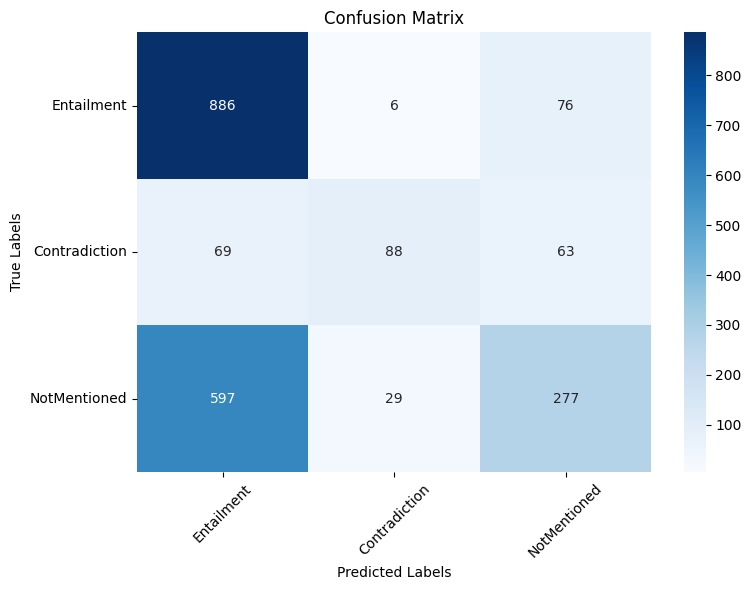

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping, yticklabels=label_mapping)

# Add labels, title, and format
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.yticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()